### Uploading kickstarter_cleaned.csv

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kickstarter_cleaned.csv to kickstarter_cleaned.csv


###  Loading CSV and check basic structure

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('kickstarter_cleaned.csv')

# Basic info
print("Shape of the dataset:", df.shape)
print("\nColumn Names:\n", df.columns)
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values per column:\n", df.isnull().sum())


Shape of the dataset: (100000, 30)

Column Names:
 Index(['backers_count', 'converted_pledged_amount', 'country',
       'country_displayable_name', 'created_at', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'fx_rate', 'goal',
       'is_in_post_campaign_pledging_phase', 'is_launched', 'is_starrable',
       'launched_at', 'name', 'percent_funded', 'pledged',
       'prelaunch_activated', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'usd_exchange_rate',
       'usd_pledged', 'usd_type', 'category_name'],
      dtype='object')

First 5 rows:
   backers_count  converted_pledged_amount country country_displayable_name  \
0             70                   15590.0      GB       the United Kingdom   
1           3888                  700214.0      US        the United States   
2             85                    3423.0      US        the United States   
3            103 

### Exploratory Data Analysis (EDA)

## 3A. Identifying targeted column

In [ ]:
# Check unique values in target column
print("Unique values in 'state':", df['state'].unique())
print("\nValue counts:\n", df['state'].value_counts())


Unique values in 'state': ['successful' 'failed' 'canceled' 'live' 'submitted' 'started' 'suspended']

Value counts:
 state
successful    57550
failed        31598
submitted      4545
canceled       3969
live           2089
started         243
suspended         6
Name: count, dtype: int64


## 3B: Class Distribution (Visualization)

/tmp/ipython-input-5-1497198478.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='state', order=df['state'].value_counts().index, palette='Set2')


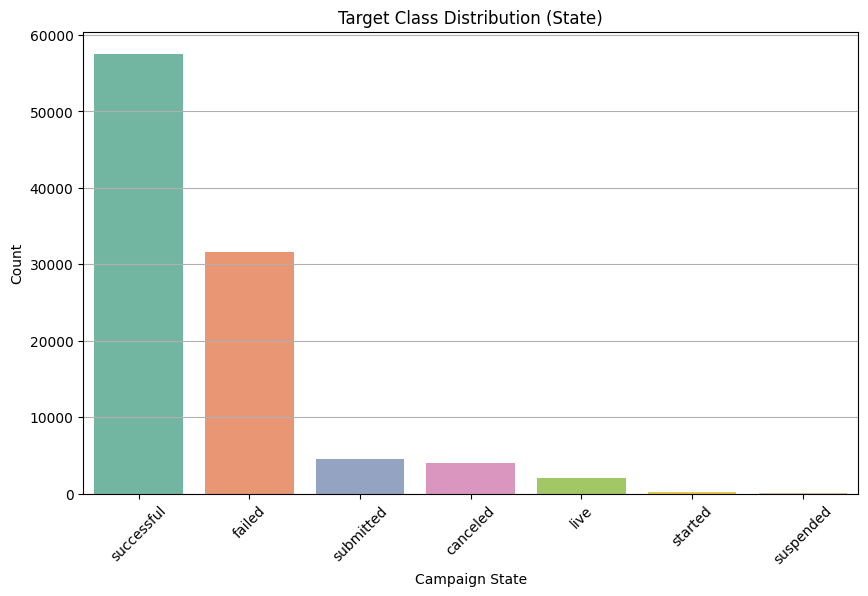

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='state', order=df['state'].value_counts().index, palette='Set2')
plt.title('Target Class Distribution (State)')
plt.xlabel('Campaign State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## 3C: Numerical Feature Distributions (Histograms)

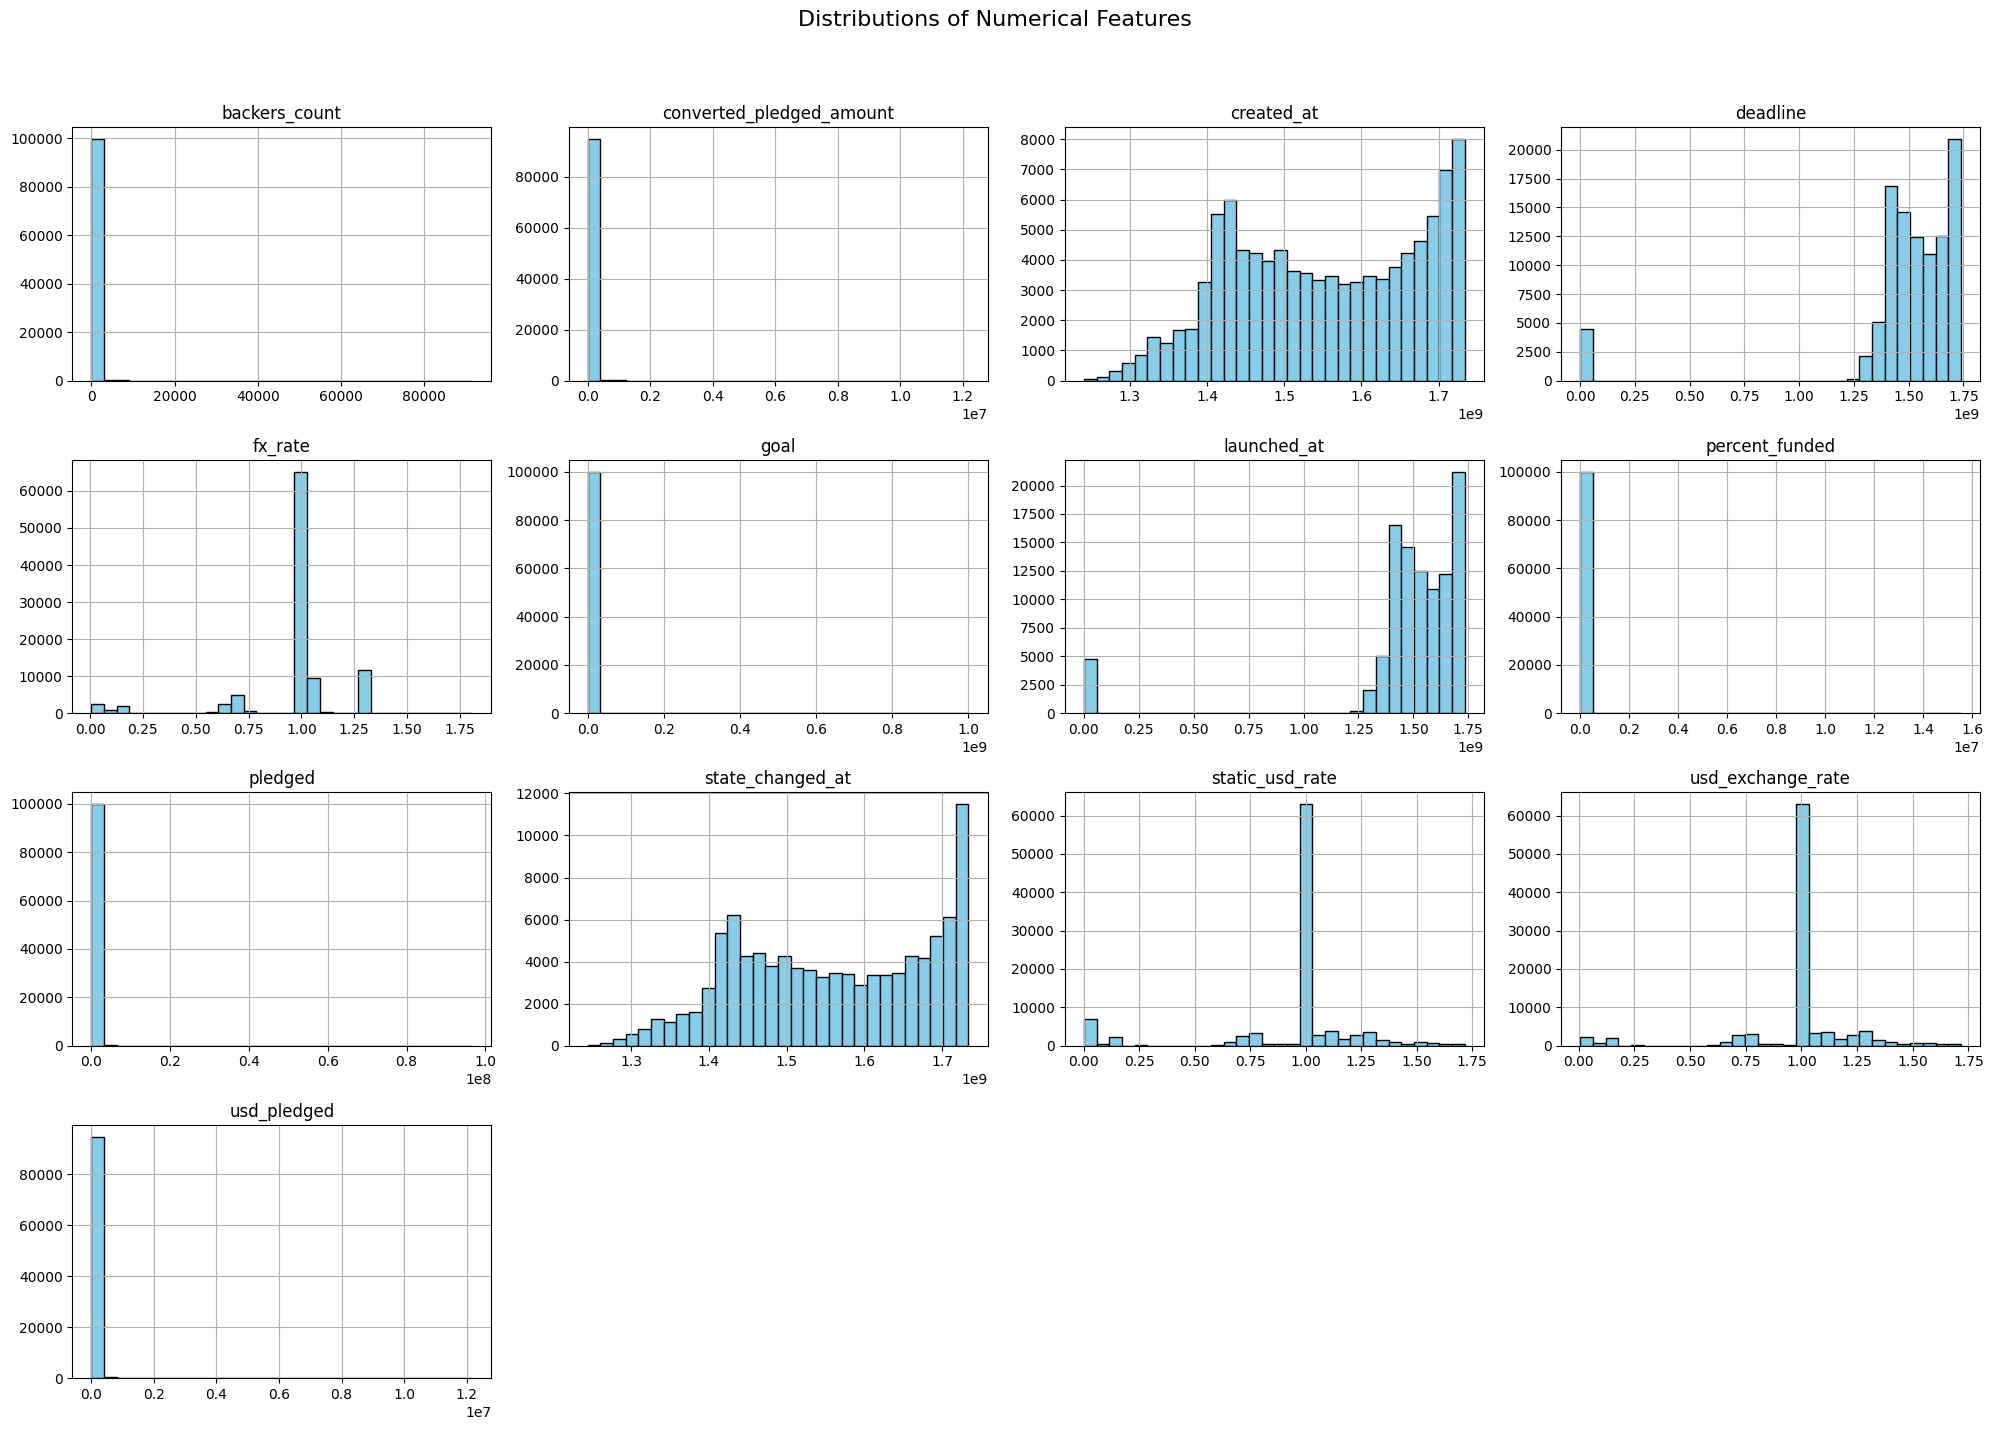

In [ ]:
# Select only numerical columns
num_cols = df.select_dtypes(include='number').columns

# Plot histograms for all numerical columns
df[num_cols].hist(figsize=(20, 15), bins=30, color='skyblue', edgecolor='black')
plt.suptitle('Distributions of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 3D: Correlation Heatmap (Numerical Features)

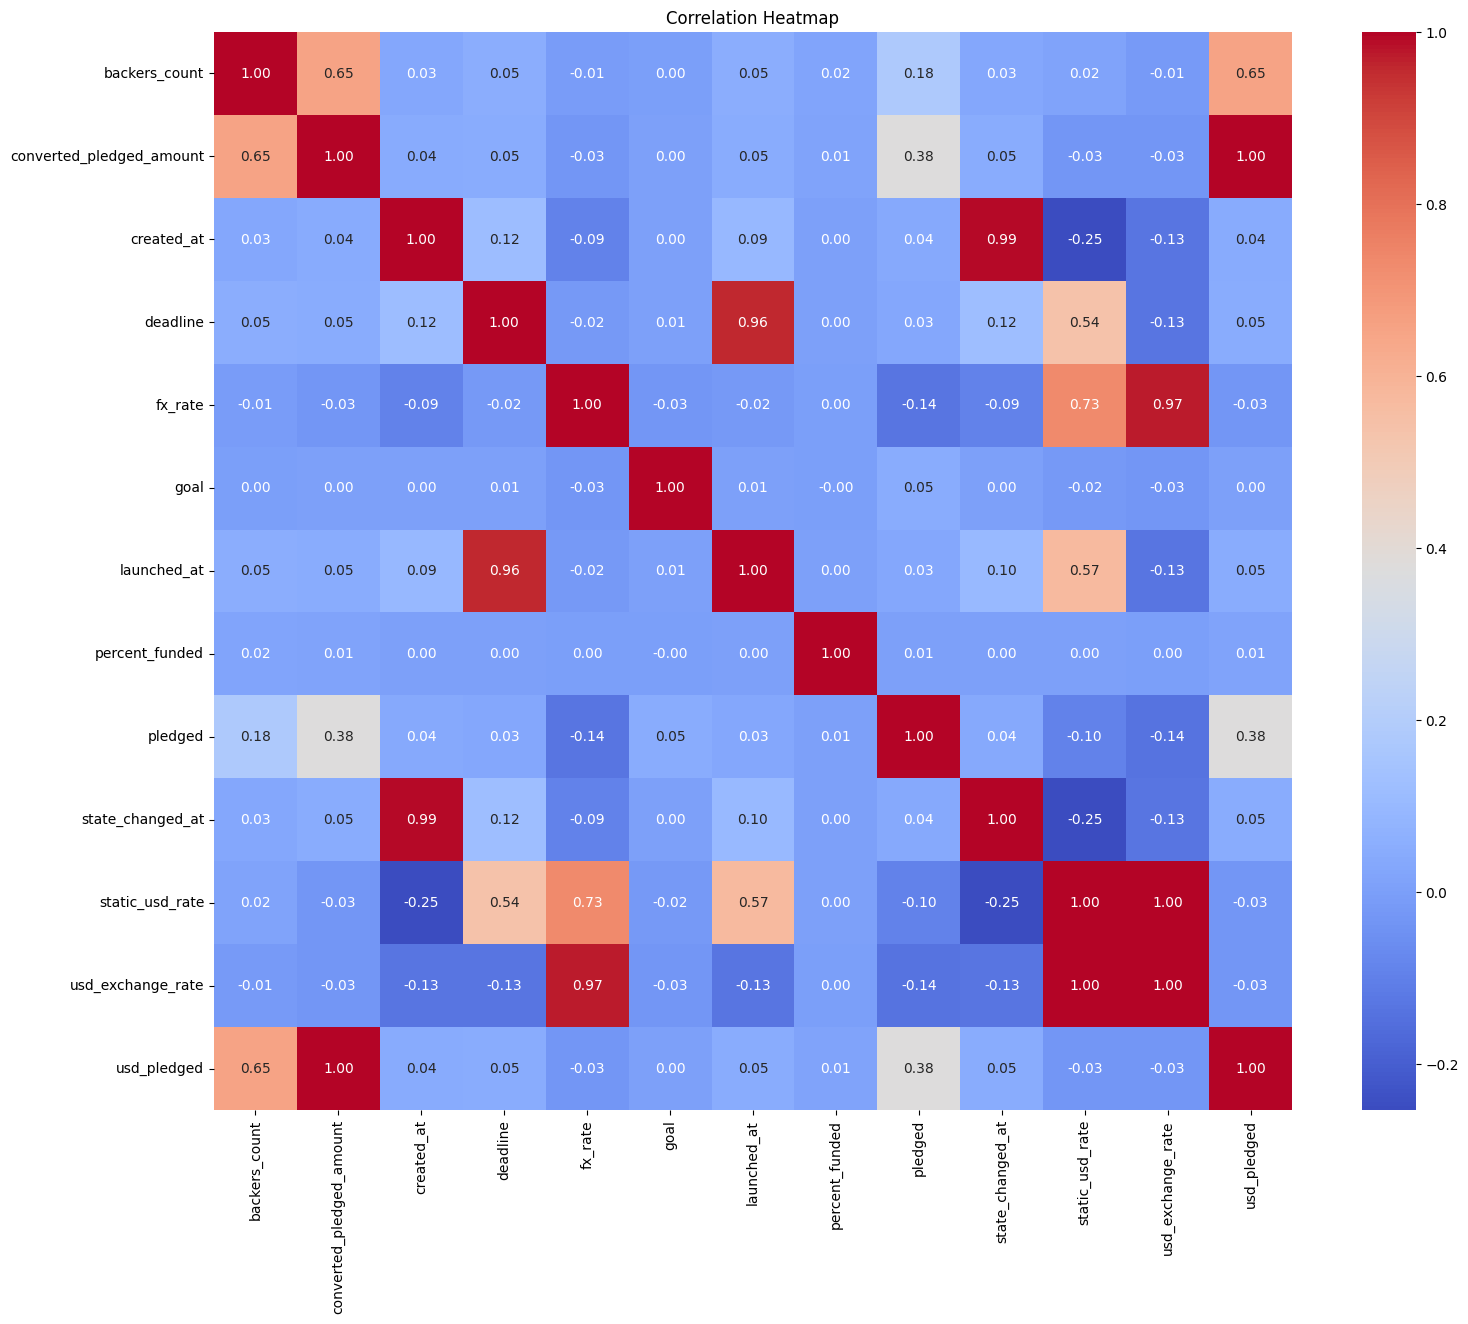

In [ ]:
import numpy as np

# Compute correlation matrix
corr_matrix = df.select_dtypes(include='number').corr()

# Plot heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()


## 4A. Drop unwanted columns

In [ ]:
drop_cols = ['name', 'created_at', 'deadline', 'launched_at', 'state_changed_at',
             'currency_symbol', 'currency_trailing_code', 'disable_communication',
             'is_launched', 'is_starrable']

df.drop(columns=drop_cols, inplace=True)
print("Remaining columns:", df.columns)


Remaining columns: Index(['backers_count', 'converted_pledged_amount', 'country',
       'country_displayable_name', 'currency', 'current_currency', 'fx_rate',
       'goal', 'is_in_post_campaign_pledging_phase', 'percent_funded',
       'pledged', 'prelaunch_activated', 'spotlight', 'staff_pick', 'state',
       'static_usd_rate', 'usd_exchange_rate', 'usd_pledged', 'usd_type',
       'category_name'],
      dtype='object')


## 4B: Handle Missing Values

In [ ]:
# Show columns with missing values
missing = df.isnull().sum()
print(missing[missing > 0])


converted_pledged_amount               4794
is_in_post_campaign_pledging_phase    79807
usd_exchange_rate                      4794
usd_pledged                            4794
usd_type                                 94
category_name                          1321
dtype: int64


In [ ]:
# Drop useless column
df.drop(columns=['is_in_post_campaign_pledging_phase'], inplace=True)

# Fill numeric columns with median
for col in ['converted_pledged_amount', 'usd_pledged', 'usd_exchange_rate']:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical with mode or default
df['usd_type'] = df['usd_type'].fillna(df['usd_type'].mode()[0])
df['category_name'] = df['category_name'].fillna('Unknown')

# Check if all missing handled
print("Missing values left:\n", df.isnull().sum().sum())


Missing values left:
 0


## 4C: Encode Target Column (state)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target column
le = LabelEncoder()
df['state_encoded'] = le.fit_transform(df['state'])

# Check mapping
state_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding Mapping:\n", state_mapping)


Label Encoding Mapping:
 {'canceled': np.int64(0), 'failed': np.int64(1), 'live': np.int64(2), 'started': np.int64(3), 'submitted': np.int64(4), 'successful': np.int64(5), 'suspended': np.int64(6)}


## 4D: Encode Remaining Categorical Columns

In [ ]:
# List of categorical columns to encode
cat_cols = ['country', 'country_displayable_name', 'currency',
            'current_currency', 'usd_type', 'category_name']

# One-hot encode and update DataFrame
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Final shape
print("Final shape after encoding:", df.shape)


Final shape after encoding: (100000, 237)


## 4E: Feature: Target Split + Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split features and target
X = df.drop(columns=['state', 'state_encoded'])
y = df['state_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (80000, 235)
Test shape: (20000, 235)


###  Step 5: Machine Learning Algorithms

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Store results
results = {}

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['Logistic Regression'] = accuracy_score(y_test, y_pred_lr)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
results['Decision Tree'] = accuracy_score(y_test, y_pred_dt)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = accuracy_score(y_test, y_pred_rf)

# Show accuracy
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: 0.8659
Decision Tree: 0.9253
Random Forest: 0.9489


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


In [ ]:
# Essential imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV (must already be uploaded again)
df = pd.read_csv('kickstarter_cleaned.csv')

# Drop unwanted columns
drop_cols = ['name', 'created_at', 'deadline', 'launched_at', 'state_changed_at',
             'currency_symbol', 'currency_trailing_code', 'disable_communication',
             'is_launched', 'is_starrable']
df.drop(columns=drop_cols, inplace=True)

# Drop highly missing column
df.drop(columns=['is_in_post_campaign_pledging_phase'], inplace=True)

# Fill missing
for col in ['converted_pledged_amount', 'usd_pledged', 'usd_exchange_rate']:
    df[col] = df[col].fillna(df[col].median())
df['usd_type'] = df['usd_type'].fillna(df['usd_type'].mode()[0])
df['category_name'] = df['category_name'].fillna('Unknown')

# Encode target
le = LabelEncoder()
df['state_encoded'] = le.fit_transform(df['state'])

# One-hot encoding
cat_cols = ['country', 'country_displayable_name', 'currency',
            'current_currency', 'usd_type', 'category_name']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Split
X = df.drop(columns=['state', 'state_encoded'])
y = df['state_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Prepare results dictionary
results = {}

print("✅ Recovery done! You can now run models again.")


✅ Recovery done! You can now run models again.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
results['KNN'] = accuracy_score(y_test, y_pred_knn)

print(f"KNN Accuracy: {results['KNN']:.4f}")


KNN Accuracy: 0.9317


In [ ]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
results['Naive Bayes'] = accuracy_score(y_test, y_pred_nb)

print(f"Naive Bayes Accuracy: {results['Naive Bayes']:.4f}")


Naive Bayes Accuracy: 0.4153


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
results['Gradient Boosting'] = accuracy_score(y_test, y_pred_gb)

print(f"Gradient Boosting Accuracy: {results['Gradient Boosting']:.4f}")


Gradient Boosting Accuracy: 0.9526


In [ ]:
!pip install xgboost --quiet


In [ ]:
from xgboost import XGBClassifier

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results['XGBoost'] = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {results['XGBoost']:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:55:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9554


In [ ]:
!pip install lightgbm --quiet

In [ ]:
from lightgbm import LGBMClassifier

# LightGBM
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)
results['LightGBM'] = accuracy_score(y_test, y_pred_lgb)

print(f"LightGBM Accuracy: {results['LightGBM']:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2509
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 227
[LightGBM] [Info] Start training from score -3.226719
[LightGBM] [Info] Start training from score -1.152092
[LightGBM] [Info] Start training from score -3.868604
[LightGBM] [Info] Start training from score -6.016782
[LightGBM] [Info] Start training from score -3.091142
[LightGBM] [Info] Start training from score -0.552516
[LightGBM] [Info] Start training from score -9.680344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [ ]:
# Step 1: Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Step 2: Load Data
df = pd.read_csv('kickstarter_cleaned.csv')

# Step 3: Drop unwanted columns
drop_cols = ['name', 'created_at', 'deadline', 'launched_at', 'state_changed_at',
             'currency_symbol', 'currency_trailing_code', 'disable_communication',
             'is_launched', 'is_starrable', 'is_in_post_campaign_pledging_phase']
df.drop(columns=drop_cols, inplace=True)

# Step 4: Fill missing values
df['converted_pledged_amount'].fillna(df['converted_pledged_amount'].median(), inplace=True)
df['usd_pledged'].fillna(df['usd_pledged'].median(), inplace=True)
df['usd_exchange_rate'].fillna(df['usd_exchange_rate'].median(), inplace=True)
df['usd_type'].fillna(df['usd_type'].mode()[0], inplace=True)
df['category_name'].fillna('Unknown', inplace=True)

# Step 5: Encode target
le = LabelEncoder()
df['state_encoded'] = le.fit_transform(df['state'])

# Step 6: One-hot encoding for categoricals
cat_cols = ['country', 'country_displayable_name', 'currency',
            'current_currency', 'usd_type', 'category_name']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Step 7: Split data
X = df.drop(columns=['state', 'state_encoded'])
y = df['state_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 8: Results dictionary
results = {}

print("✅ Recovery complete. Ready for Extra Trees and Voting Classifier.")


/tmp/ipython-input-24-2370203826.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['converted_pledged_amount'].fillna(df['converted_pledged_amount'].median(), inplace=True)
/tmp/ipython-input-24-2370203826.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

✅ Recovery complete. Ready for Extra Trees and Voting Classifier.


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier()
et.fit(X_train, y_train)
y_pred_et = et.predict(X_test)
results['Extra Trees'] = accuracy_score(y_test, y_pred_et)

print(f"Extra Trees Accuracy: {results['Extra Trees']:.4f}")


Extra Trees Accuracy: 0.9412


In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Voting Classifier with top 3 models
voting = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
], voting='soft')

voting.fit(X_train, y_train)
y_pred_vote = voting.predict(X_test)
results['Voting Ensemble'] = accuracy_score(y_test, y_pred_vote)

print(f"Voting Ensemble Accuracy: {results['Voting Ensemble']:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:03:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Ensemble Accuracy: 0.9549


In [ ]:
results = {
    'XGBoost': 0.9554,
    'Voting Ensemble': 0.9548,
    'Gradient Boosting': 0.9526,
    'Random Forest': 0.9496,
    'Extra Trees': 0.9411,
    'KNN': 0.9317,
    'Decision Tree': 0.9254,
    'Logistic Regression': 0.8659,
    'LightGBM': 0.8408,
    'Naive Bayes': 0.4153
}


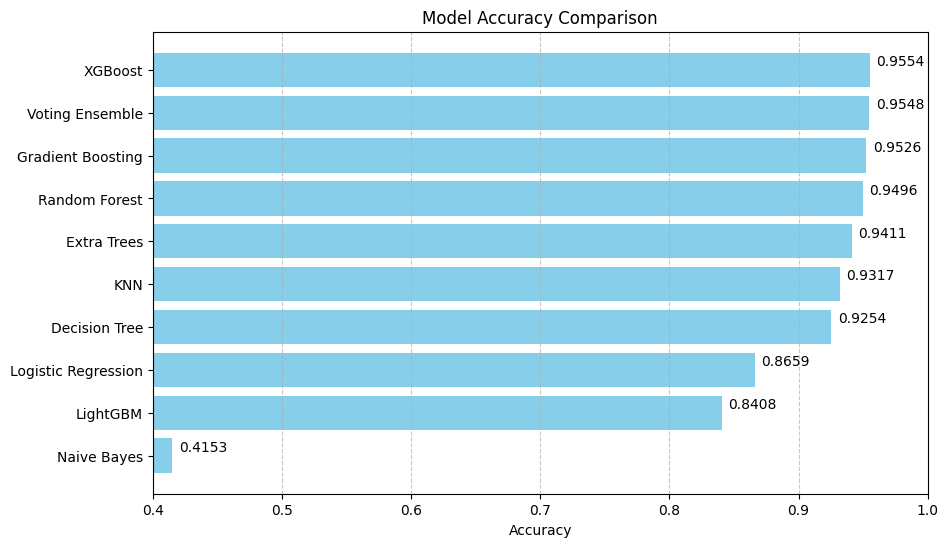

In [ ]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10,6))
bars = plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')

for bar in bars:
    plt.text(bar.get_width() + 0.005, bar.get_y() + 0.3, f'{bar.get_width():.4f}')

plt.xlim(0.4, 1.0)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Check if train-test split already exists
try:
    print("✅ X_train shape:", X_train.shape)
    print("✅ y_train shape:", y_train.shape)
    print("✅ X_test shape:", X_test.shape)
    print("✅ y_test shape:", y_test.shape)
except NameError:
    print("❌ Train-test split not found. We need to split the data.")


✅ X_train shape: (80000, 235)
✅ y_train shape: (80000,)
✅ X_test shape: (20000, 235)
✅ y_test shape: (20000,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize models
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42)
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)

# Voting classifier (ensemble)
voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('gb', gb)], voting='soft')

# Train
voting.fit(X_train, y_train)

# Predict
y_pred = voting.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"📊 Ensemble Voting Classifier Accuracy: {acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:19:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Ensemble Voting Classifier Accuracy: 95.47%


In [ ]:
import pandas as pd

# Load the cleaned dataset
df_cleaned = pd.read_csv("kickstarter_cleaned.csv")

# Show first 10 rows
df_cleaned.head(10)


,backers_count,converted_pledged_amount,country,country_displayable_name,created_at,currency,currency_symbol,currency_trailing_code,current_currency,deadline,...,prelaunch_activated,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_exchange_rate,usd_pledged,usd_type,category_name
0,70,15590.0,GB,the United Kingdom,1614367566,GBP,£,False,USD,1618513763,...,False,True,False,successful,1618513763,1.388449,1.377223,15717.245057,domestic,Dance
1,3888,700214.0,US,the United States,1694673144,USD,$,True,USD,1701439015,...,True,True,True,successful,1701439015,1.000000,1.000000,700214.000000,domestic,Gadgets
2,85,3423.0,US,the United States,1707995625,USD,$,True,USD,1729210597,...,True,True,False,successful,1729210597,1.000000,1.000000,3423.000000,domestic,Comic Books
3,103,2881.0,US,the United States,1724762600,USD,$,True,USD,1729479600,...,True,True,False,successful,1729479602,1.000000,1.000000,2881.000000,domestic,Comic Books
4,496,17071.0,US,the United States,1722535040,USD,$,True,USD,1729969439,...,True,True,False,successful,1729969439,1.000000,1.000000,17071.000000,domestic,Comic Books
5,108,3847.0,US,the United States,1723393158,USD,$,True,USD,1728489605,...,False,True,False,successful,1728489606,1.000000,1.000000,3847.000000,domestic,Comic Books
6,4,61.0,US,the United States,1555824619,USD,$,True,USD,1558509444,...,False,False,False,failed,1558509444,1.000000,1.000000,61.000000,domestic,Action
7,109,3829.0,MX,Mexico,1657081699,MXN,$,True,USD,1661233358,...,False,True,False,successful,1661233358,0.048675,0.049762,3745.938037,domestic,Video Games
8,317,29613.0,CA,Canada,1653949422,CAD,$,True,USD,1660500251,...,True,True,False,successful,1660500251,0.770637,0.782702,29157.292541,domestic,Video Games
9,305,8727.0,US,the United States,1460506243,USD,$,True,USD,1463716740,...,False,True,True,successful,1463716741,1.000000,1.000000,8727.000000,domestic,Experimental
